# テーブル作成の続き & 季節性の確認

## パーツのワランティ件数の生産台数に対する割合(累積ベース, 時系列)

In [1]:
from sqlalchemy import create_engine
from pathlib import Path

# DBのpathにあわせて変更を要する
PATH_DB = Path("../data/interim/suzuki_phase2_db.sqlite3")
engine = create_engine(f"sqlite:///{PATH_DB.as_posix()}")

In [2]:
import pandas as pd

pd.read_sql("select * from dbhaa_all limit 5;", engine)

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,...,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,WRAEID200608B000001,118700,118700,1,B,1,200608,5725,AE,0607003,...,0.0,296.0,1753.0,None,0,0.0,12,3,None,17-06-20 14:01:16.950054000
1,WRAEID200608B000002,118700,118700,1,B,1,200608,5725,AE,0607006,...,3528.0,0.0,5174.0,None,0,0.0,12,3,None,17-06-20 14:01:16.952369000
2,WRAEID200608B000003,118700,118700,1,B,1,200608,5725,AE,0607001,...,3528.0,0.0,5174.0,None,0,0.0,13,5,None,17-06-20 14:01:16.954219000
3,WRAEID200608B000004,118700,118700,1,B,1,200608,5725,AE,0607002,...,3528.0,0.0,5174.0,None,0,0.0,13,3,None,17-06-20 14:01:16.956251000
4,WRAEID200608B000005,118700,118700,1,B,1,200608,5725,AE,0607004,...,0.0,1714.0,8606.0,None,0,0.0,12,4,None,17-06-20 14:01:16.957878000


### 日次ワランティ件数推移

In [3]:
%%time

# 通期(データ全体)で見た場合の、モデル x パーツ x 月毎のワランティ数を確認
# モデルコードを上3に絞って集計
# 国内で生産され、国内に出荷された四輪に限定。

df_warranty_model_part_num_daily = pd.read_sql(
    """
    select
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,W_FAILURE_DATE as date
        ,count(*) as n
    from
        dbhaa_all
    where
        W_PROD_BASE_CD = "100100"
        and W_BASE_CD = "100100"
        and W_PROD_DIV = "B"
        and W_DMEX_DIV = "0"
    group by
        model_cd, part_cd, date;
    """
    , engine)

CPU times: user 30.8 s, sys: 12.1 s, total: 42.9 s
Wall time: 57.8 s


In [4]:
df_warranty_model_part_num_daily.head()

,model_cd,part_cd,date,n
0,None,*0000-000,20030122,1
1,None,*1110-CT5,20000616,1
2,None,*1110-CT5,20010706,1
3,None,*1110-DC5,20010110,1
4,None,*1110-MA6,20000205,1


In [5]:
df_warranty_model_part_num_daily.shape

(4307100, 4)

In [6]:
# 個々人のfolder構成に応じて変更を要する
PATH_INTERIM_DATA = Path("../data/interim/")

In [7]:
df_warranty_model_part_num_daily.to_feather(PATH_INTERIM_DATA/"df_warranty_model_part_num_daily.feather")

In [8]:
df_warranty_model_part_num_daily = pd.read_feather(PATH_INTERIM_DATA/"df_warranty_model_part_num_daily.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


### 経過月毎ワランティ数

In [9]:
%%time

# 通期(データ全体)で見た場合の、モデル x パーツ x 経過月毎のワランティ数を確認
# モデルコードを上3に絞って集計
# 国内で生産され、国内に出荷された四輪に限定。

df_warranty_model_part_num_month_passed = pd.read_sql(
    """
    select
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,W_SALES_TO_FAILURE as month_passed
        ,count(*) as n
    from
        dbhaa_all
    where
        W_PROD_BASE_CD = '100100'
        and W_PROD_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
    group by
        model_cd, part_cd, month_passed;
    """
    , engine)

CPU times: user 20.2 s, sys: 7.74 s, total: 28 s
Wall time: 35.6 s


In [10]:
df_warranty_model_part_num_month_passed.shape

(1039869, 4)

In [11]:
df_warranty_model_part_num_month_passed.head(3)

,model_cd,part_cd,month_passed,n
0,None,*0000-000,67,1
1,None,*1110-CT5,29,1
2,None,*1110-CT5,47,1


In [12]:
df_warranty_model_part_num_month_passed.model_cd.nunique()

84

In [13]:
df_warranty_model_part_num_month_passed.to_feather(
    PATH_INTERIM_DATA/"df_warranty_model_part_num_month_passed.feather")

In [14]:
df_warranty_model_part_num_month_passed = pd.read_feather(
    PATH_INTERIM_DATA/"df_warranty_model_part_num_month_passed.feather")

#### 経過日毎ワランティ数

In [15]:
pd.set_option("display.max_columns", 1000)
pd.read_sql("select * from dbhaa_all limit 5;", engine)

,W_KEY,W_BASE_CD,W_PROD_BASE_CD,W_FIELD_CLAIM_DIV,W_PROD_DIV,W_DMEX_DIV,W_PROCESS_MONTH,W_DIST_CD,W_DIST_COUNTRY_CD,W_DIST_ISSUE_NO,W_SHOP_DIV,W_SHOP_CD,W_DIV1,W_DIV2,W_DIV3,W_FIXED_DIV,W_MINUS_DIV,W_SRC_DIV,W_SRC_KEY,W_VIN,W_FCOK,W_PROD_MODEL_CD,W_SALES_DATE,W_FAILURE_DATE,W_MILEAGE_DIV,W_MILEAGE,W_CAUSAL_PART_NO,W_TROUBLE_CC,W_TROUBLE_CP,W_TROUBLE_DF,W_TROUBLE_MP,W_DTC_1,W_DTC_2,W_OPERATION_CD,W_PARTS_AMT,W_LABOR_HOUR,W_LABOR_AMT,W_SUBLET_HOUR,W_SUBLET_AMT,W_SHIPPING_AMT,W_TOTAL_AMT,W_CFC_COMPANY_CD,W_CFC_RATE,W_CFC_AMT,W_FC_TO_FAILURE,W_SALES_TO_FAILURE,W_SB_NO,W_CRT_TIME_STAMP
0,WRAEID200608B000001,118700,118700,1,B,1,200608,5725,AE,0607003,None,None,None,0,0,1,1,2,2006085725B00607003,MHYDN71V45J101139,20050702,YL0A1N7E,20060328,20060617,K,5092,84703-61J00-6GS,None,76,48,None,None,None,QJ04R0,987.0,0.2,470.0,0.0,0.0,296.0,1753.0,None,0,0.0,12,3,None,17-06-20 14:01:16.950054000
1,WRAEID200608B000002,118700,118700,1,B,1,200608,5725,AE,0607006,None,None,None,0,0,1,1,2,2006085725B00607006,MHYDN71V45J101139,20050702,YL0A1N7E,20060328,20060621,K,7783,48830-61J00,None,41,48,None,None,None,LC9999,0.0,0.7,1646.0,1.5,3528.0,0.0,5174.0,None,0,0.0,12,3,None,17-06-20 14:01:16.952369000
2,WRAEID200608B000003,118700,118700,1,B,1,200608,5725,AE,0607001,None,None,None,0,0,1,1,2,2006085725B00607001,MHYDN71V55J101134,20050630,YL0A1N7E,20060116,20060612,K,1182,48830-61J00,None,41,48,None,None,None,LC9999,0.0,0.7,1646.0,1.5,3528.0,0.0,5174.0,None,0,0.0,13,5,None,17-06-20 14:01:16.954219000
3,WRAEID200608B000004,118700,118700,1,B,1,200608,5725,AE,0607002,None,None,None,0,0,1,1,2,2006085725B00607002,MHYDN71V35J101147,20050630,YL0A1N7E,20060329,20060614,K,2061,48830-61J00,None,41,48,None,None,None,LC9999,0.0,0.7,1646.0,1.5,3528.0,0.0,5174.0,None,0,0.0,13,3,None,17-06-20 14:01:16.956251000
4,WRAEID200608B000005,118700,118700,1,B,1,200608,5725,AE,0607004,None,None,None,0,0,1,1,2,2006085725B00607004,MHYDN71V45J101125,20050701,YL0A1N7E,20060225,20060619,K,8050,14190-61J00,None,84,15,None,None,None,DA14R0,5716.0,0.5,1176.0,0.0,0.0,1714.0,8606.0,None,0,0.0,12,4,None,17-06-20 14:01:16.957878000


In [16]:
%%time

# 通期(データ全体)で見た場合の、モデル x パーツ x 経過日毎のワランティ数を確認
# モデルコードを上3に絞って集計
# 国内で生産され、国内に出荷された四輪に限定。

df_warranty_model_part_num_date_passed = pd.read_sql(
    """
    select
        substr(W_PROD_MODEL_CD, 1, 3) as model_cd
        ,substr(W_CAUSAL_PART_NO, 1, 9) as part_cd
        ,date(W_FAILURE_DATE) - date(W_SALES_DATE) as date_passed
        ,W_SALES_TO_FAILURE as month_passed
        ,count(*) as n
    from
        dbhaa_all
    where
        W_PROD_BASE_CD = '100100'
        and W_PROD_BASE_CD = '100100'
        and W_PROD_DIV = 'B'
        and W_DMEX_DIV = '0'
    group by
        model_cd, part_cd, month_passed, date_passed;
    """
    , engine)

CPU times: user 24 s, sys: 6.28 s, total: 30.2 s
Wall time: 34.7 s


In [17]:
df_warranty_model_part_num_date_passed.shape

(1039869, 5)

In [18]:
df_warranty_model_part_num_date_passed.to_feather(
    PATH_INTERIM_DATA/"df_warranty_model_part_num_date_passed.feather")
df_warranty_model_part_num_date_passed = pd.read_feather(
    PATH_INTERIM_DATA/"df_warranty_model_part_num_date_passed.feather")

### 日次生産数

In [19]:
%%time

# 通期(データ全体)で見た場合の、モデル毎の月毎の生産数を確認
# モデルコードを上3桁に絞って集計
# 国内で生産された四輪に限定。

df_fcok_model_num_daily = pd.read_sql(
    """
    select
        substr(V_PROD_MODEL_CD, 1, 3) as prod_cd
        ,V_FCOK as date
        ,count(*) as n
    from
        tbhaa_all
    where
        V_BASE_CD = "100100"
        and V_PROD_DIV = "B"
    group by
        prod_cd, date;
    """
    , engine)

CPU times: user 25.8 s, sys: 14.6 s, total: 40.5 s
Wall time: 1min 16s


In [20]:
df_fcok_model_num_daily.shape

(106167, 3)

In [21]:
df_fcok_model_num_daily.head()

,prod_cd,date,n
0,None,20010521,8
1,None,20010523,1
2,None,20010604,1
3,None,20010605,3
4,None,20010611,4


In [22]:
df_fcok_model_num_daily.prod_cd.nunique() # 116機種

116

In [23]:
df_fcok_model_num_daily.to_feather(PATH_INTERIM_DATA/"df_fcok_model_num_daily.feather")

In [24]:
df_fcok_model_num_daily = pd.read_feather(PATH_INTERIM_DATA/"df_fcok_model_num_daily.feather")

In [25]:
df_fcok_model_num_daily["date"] = pd.to_datetime(df_fcok_model_num_daily["date"].astype(str))

In [26]:
df_warranty_model_part_num_daily["date"] = pd.to_datetime(df_warranty_model_part_num_daily["date"].astype(str))

In [27]:
parts_top = (df_warranty_model_part_num_daily
             .groupby("part_cd")["n"]
             .sum()
             .sort_values(ascending=False))

In [28]:
parts_top.head()

part_cd
27610-76G    340055
95411-82K    107101
14200-588    104781
95410-82K     85231
85104-82K     83442
Name: n, dtype: int64

In [29]:
print("number of warranty whose part is null:{:,}".format(df_warranty_model_part_num_daily
                                      .loc[df_warranty_model_part_num_daily.part_cd.isna(), "n"]
                                      .sum()))
print("number of warranty whose model is null:{:,}".format(df_warranty_model_part_num_daily
                                       .loc[df_warranty_model_part_num_daily.model_cd.isna(), "n"]
                                       .sum()))

number of warranty whose part is null:0
number of warranty whose model is null:1,273,433


In [30]:
# パーツコードマスタを作成。どの主原因品番がどのモデルに含まれているのかの読み替え表を作成

df_part_model_master = (df_warranty_model_part_num_daily
                        .groupby(["part_cd", "model_cd"])["n"]
                        .sum())

In [31]:
df_part_model_master.shape

(72532,)

(0, 1.035704240886781)

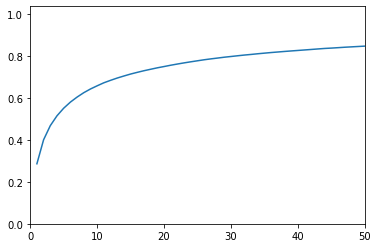

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
(df_part_model_master.value_counts().sort_index().cumsum() / df_part_model_master.shape[0]).plot()
plt.xlim(0, 50)
plt.ylim(0,)

In [35]:
df_part_model_master.value_counts().sort_index()[:15]

1     20738
2      8292
3      4869
4      3413
5      2621
6      2104
7      1736
8      1523
9      1280
10     1098
11     1045
12      847
13      794
14      706
15      676
Name: n, dtype: int64

少数しか存在しないパーツ-モデルペアが相当ある。10件以下のペア種類だけで、全ペア種類の65%程度を占める

In [36]:
# threshold: 10
df_part_model_master_selected = df_part_model_master[df_part_model_master >= 10].reset_index()

In [37]:
df_part_model_master_selected.shape

(25956, 3)

In [38]:
from datetime import datetime

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt

In [40]:
import math

def calc_cumsum(series, freq="MS", method="ffill"):
    return series.cumsum().resample(freq).first().fillna(method=method)

def plot_warranty_ratio(cum_ratio=False, plot_denom=True, plot_numer=False,
                        denom_cumsum=False, numer_cumsum=True,
                        freq="MS", topN=30, figsize=(30,15), subplot_col=6):
    
    fig = plt.figure(figsize=figsize)

    # ワランティ件数上位Nパーツについて図示
    for i, p in enumerate(parts_top.index[:topN]):
        ax = fig.add_subplot(math.ceil(topN / subplot_col), subplot_col, i + 1)
        # 対象パーツを含む機種
        model_having_parts = (df_part_model_master_selected
                              .loc[df_part_model_master_selected.part_cd == p, "model_cd"].values)

        # get number of produced model having specified parts
        fcok_model_having_parts = (df_fcok_model_num_daily
                                   .loc[df_fcok_model_num_daily.prod_cd.isin(model_having_parts)]
                                   .groupby(pd.Grouper(key="date", freq=freq))["n"]
                                   .sum()
                                   .sort_index())

        # get number of warranty of specified parts
        warranty_having_parts = (df_warranty_model_part_num_daily
                                 .loc[df_warranty_model_part_num_daily.part_cd == p]
                                 .groupby(pd.Grouper(key="date", freq=freq))["n"]
                                 .sum()
                                 .sort_index())

        # number of parts running = cumsum{fcok - warranty(1month lagged)}
        n_part = fcok_model_having_parts.subtract(warranty_having_parts.shift(), fill_value=0)
        n_part_running = calc_cumsum(n_part, freq=freq)

        # pct of warranty in running parts
        if cum_ratio:
            pct_w = calc_cumsum(warranty_having_parts, freq=freq) / n_part_running 
        else:
            pct_w = warranty_having_parts / n_part_running 
            
        pct_w.plot(ax=ax, style="o-", label="failure ratio", title=p)

        # formatting y-ticks to percent
        # ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
        ax.set_xlim(datetime(1996,10,1), datetime(2019,4,1))
        if pct_w.max() > 1: ax.set_ylim(0, 0.3) # 極端に大きい値は表示しない

        if plot_denom:
            ax2 = ax.twinx()
            if denom_cumsum:
                calc_cumsum(warranty_having_parts, freq=freq).plot(ax=ax2, color="red",
                                                                  style="--", label="cumsum #warranty")
            else:
                warranty_having_parts.plot(ax=ax2, color="red", style="--", label="#warranty")
            ax2.set_xlim(datetime(1996,10,1), datetime(2019,4,1))
        
        if plot_numer:
            ax3 = ax.twinx()
            if numer_cumsum:
                n_part_running.plot(ax=ax3, color="green", style=":", label="cumsum #parts")
            else:
                n_part.plot(ax=ax3, color="green", style=":", label="#parts")
            ax3.set_xlim(datetime(1996,10,1), datetime(2019,4,1))
        
    plt.tight_layout()
    plt.show()

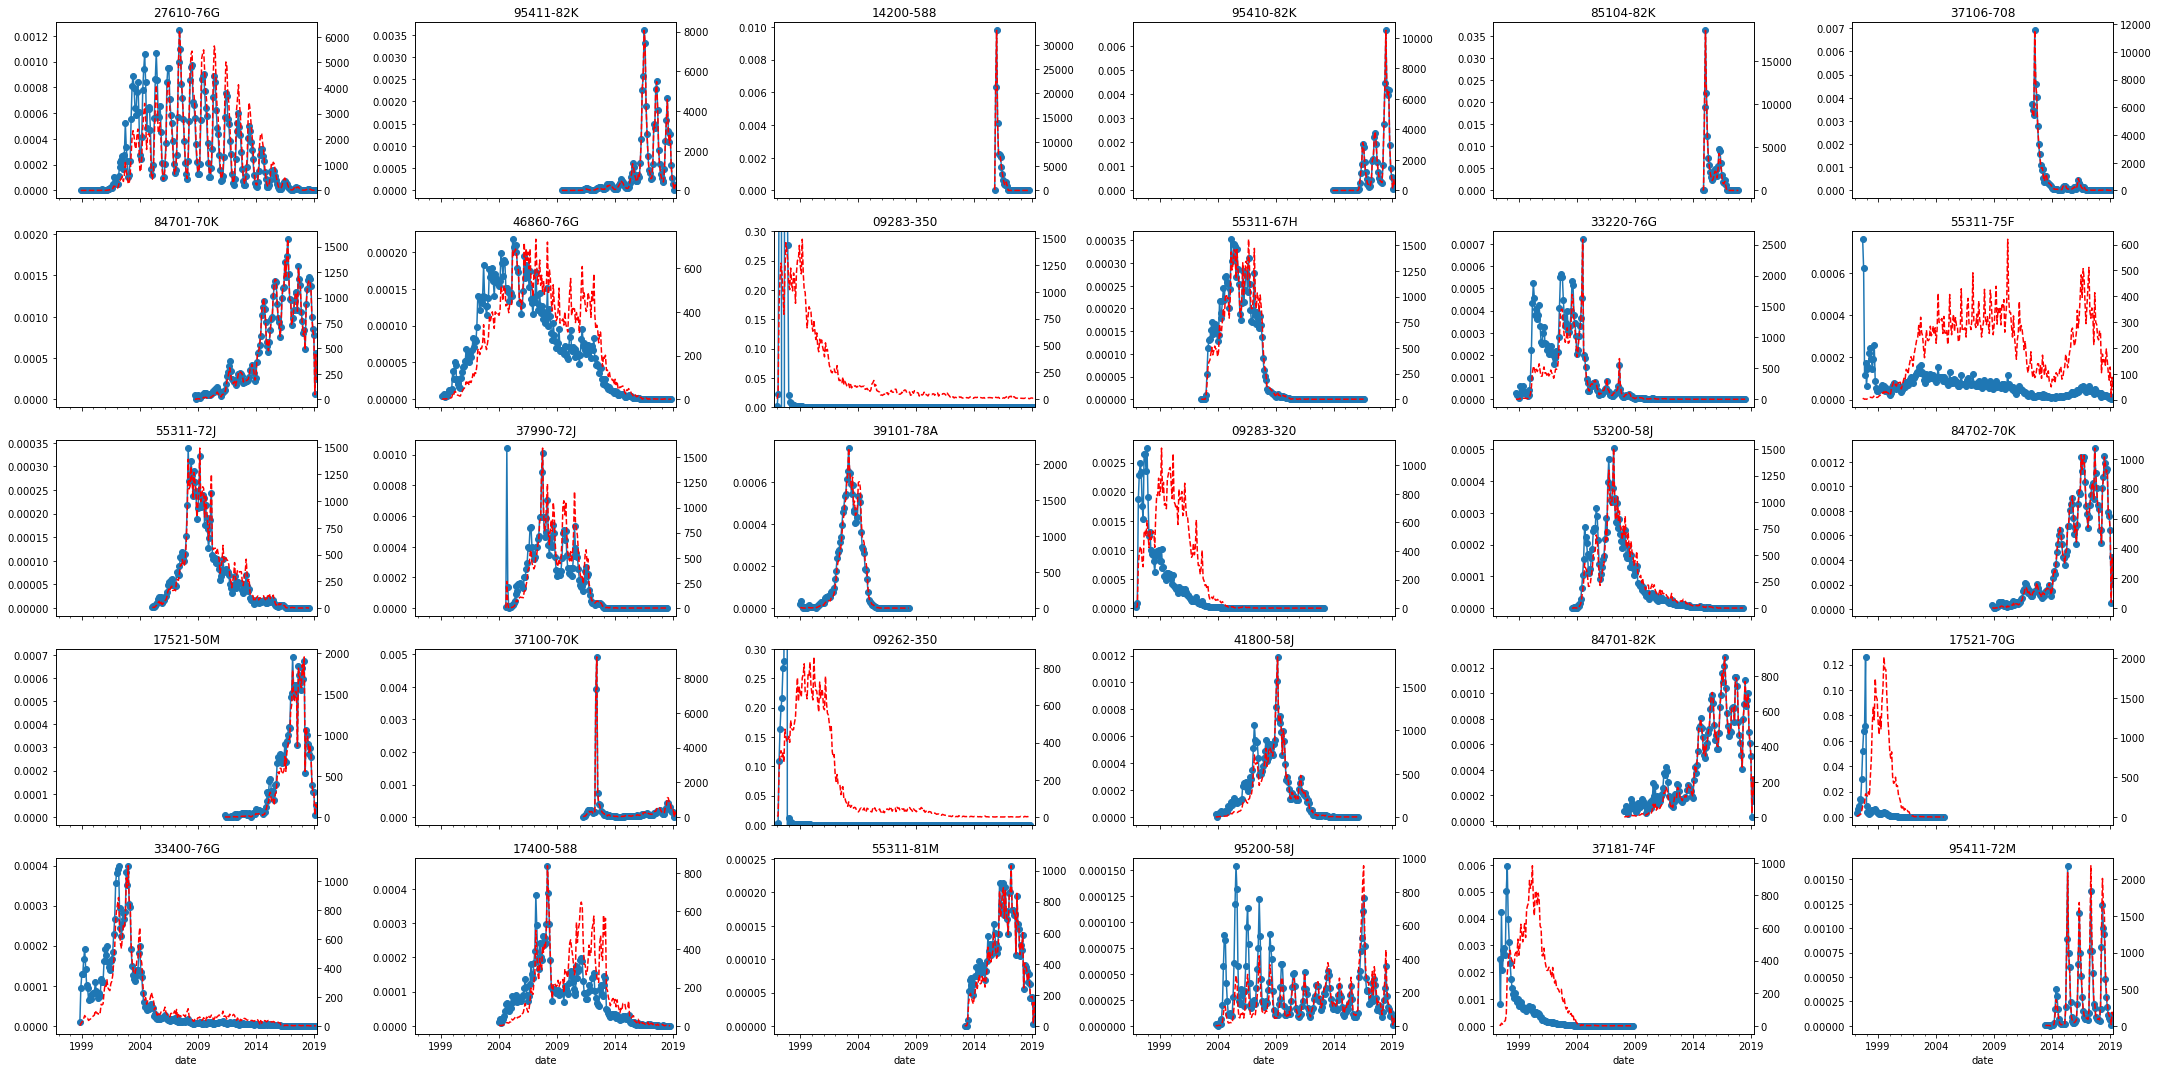

In [41]:
plot_warranty_ratio()

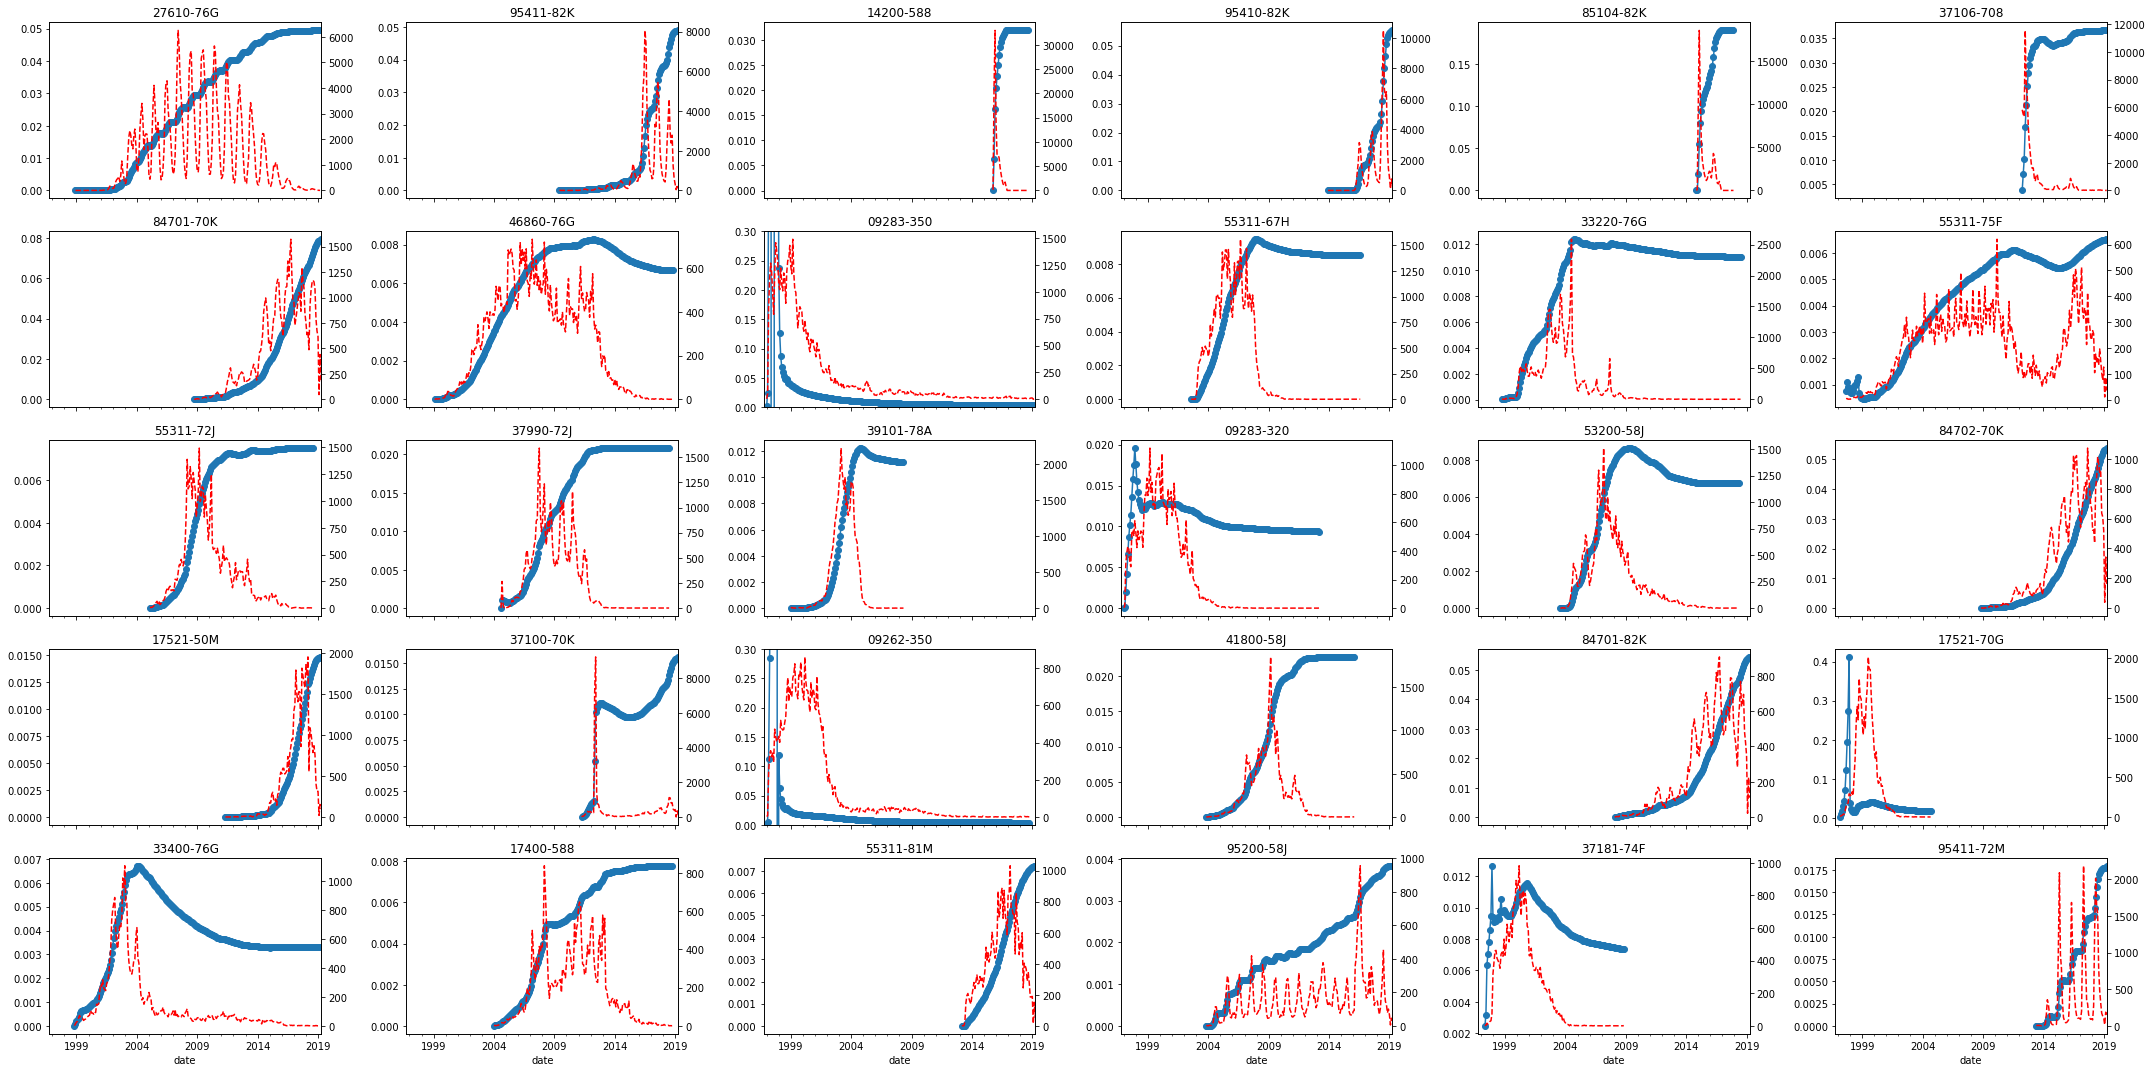

In [42]:
plot_warranty_ratio(cum_ratio=True)

徐々に上昇していき、一定の水準で沈静化する。

In [43]:
selected_td = ["27610-76G", "37950-58J", "95411-82K", "09283-350", "33920-77F",
               "33220-76G", "55311-75F", "55311-72J", "53200-58J", "84702-70K"]

selected_sz = ["95200-58J", "09262-350", "37990-72J", "46860-76G", "17400-588"]

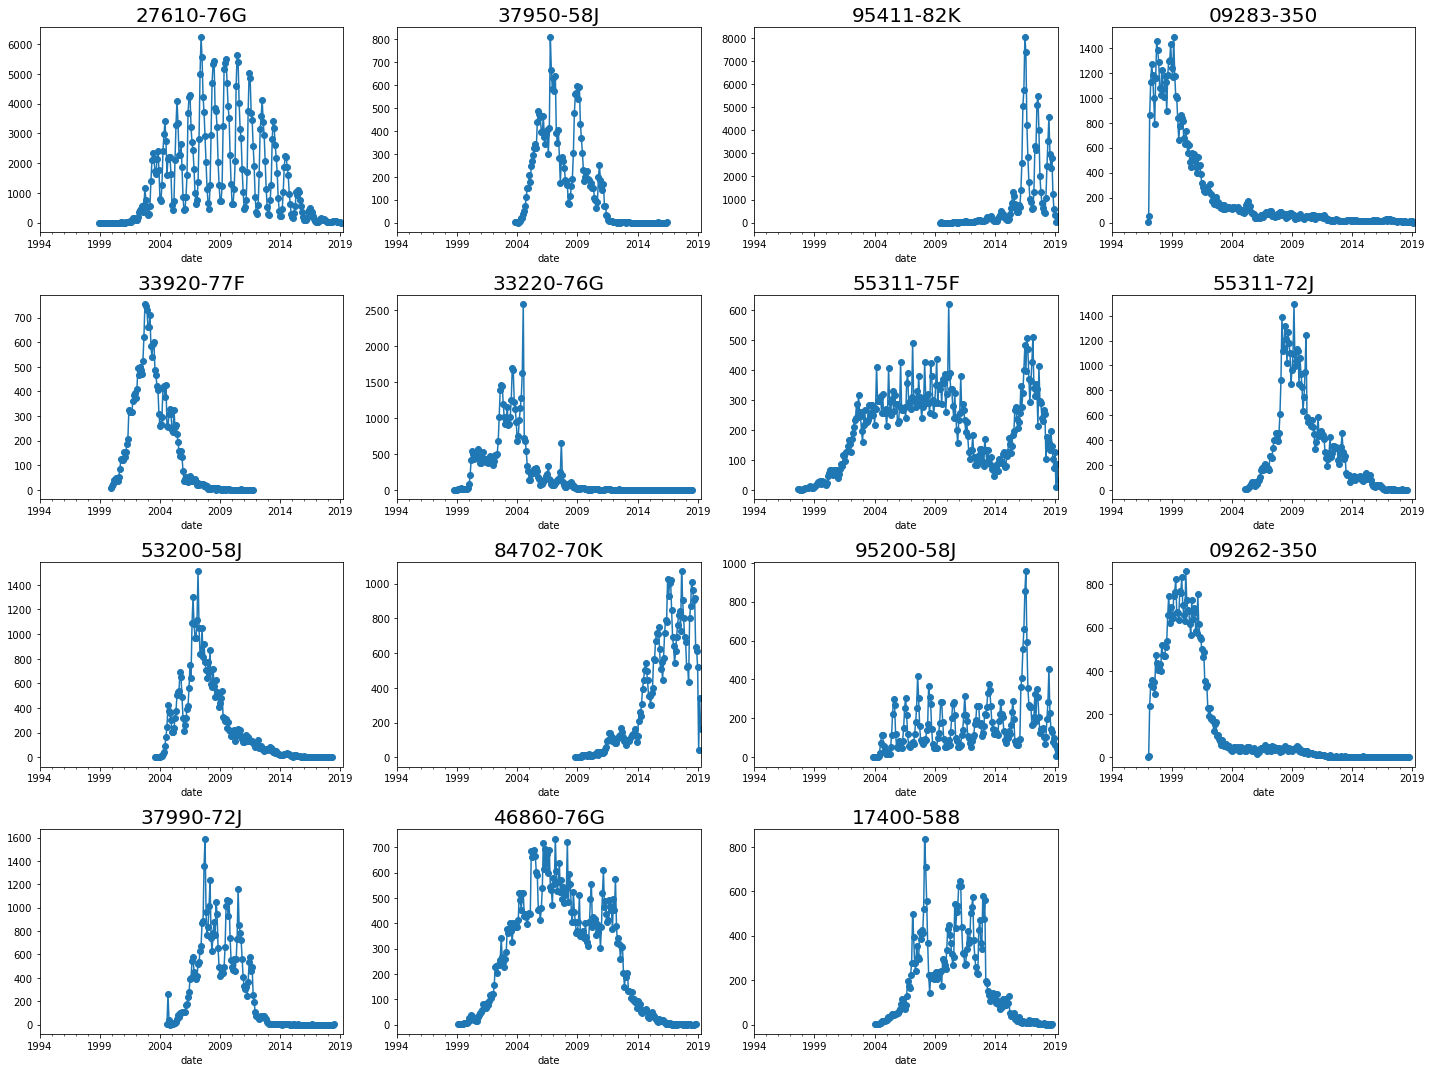

In [44]:
plt.figure(figsize=(20,15))
for i, m in enumerate(selected_td + selected_sz):
    plt.subplot(4,4,i+1)
    val = (df_warranty_model_part_num_daily
           .loc[df_warranty_model_part_num_daily.part_cd == m]
           .groupby(pd.Grouper(key="date",freq="MS"))["n"]
           .sum())
    val.plot(style="o-")
    plt.title(m, fontsize=20)
    plt.xlim(datetime(1994,1,1),datetime(2019,4,1))
plt.tight_layout()
plt.show()

## パーツのワランティ件数の生産台数に対する割合(累積ベース, 経過月)

In [45]:
df_fcok_model_num_daily.head()

,prod_cd,date,n
0,None,2001-05-21,8
1,None,2001-05-23,1
2,None,2001-06-04,1
3,None,2001-06-05,3
4,None,2001-06-11,4


In [46]:
def calc_passed(series, basedate, unit="month"):
    if unit=="month": 
        baseyear, basemonth = basedate.year, basedate.month
        return 12 * (baseyear - series.dt.year) + (basemonth - series.dt.month)
    else:
        return (basedate - series).dt.days

In [47]:
df_fcok_model_num_daily.head()

,prod_cd,date,n
0,None,2001-05-21,8
1,None,2001-05-23,1
2,None,2001-06-04,1
3,None,2001-06-05,3
4,None,2001-06-11,4


In [48]:
df_fcok_model_num_passed = df_fcok_model_num_daily.copy()

# 最終時点を2019/4/1とする
df_fcok_model_num_passed["month_passed"] = calc_passed(df_fcok_model_num_passed.date,
                                                      datetime(2019,4,1), unit="month")
df_fcok_model_num_passed["date_passed"] = calc_passed(df_fcok_model_num_passed.date,
                                                      datetime(2019,4,1), unit="date")

In [49]:
df_fcok_model_num_passed.head()

,prod_cd,date,n,month_passed,date_passed
0,None,2001-05-21,8,215,6524
1,None,2001-05-23,1,215,6522
2,None,2001-06-04,1,214,6510
3,None,2001-06-05,3,214,6509
4,None,2001-06-11,4,214,6503


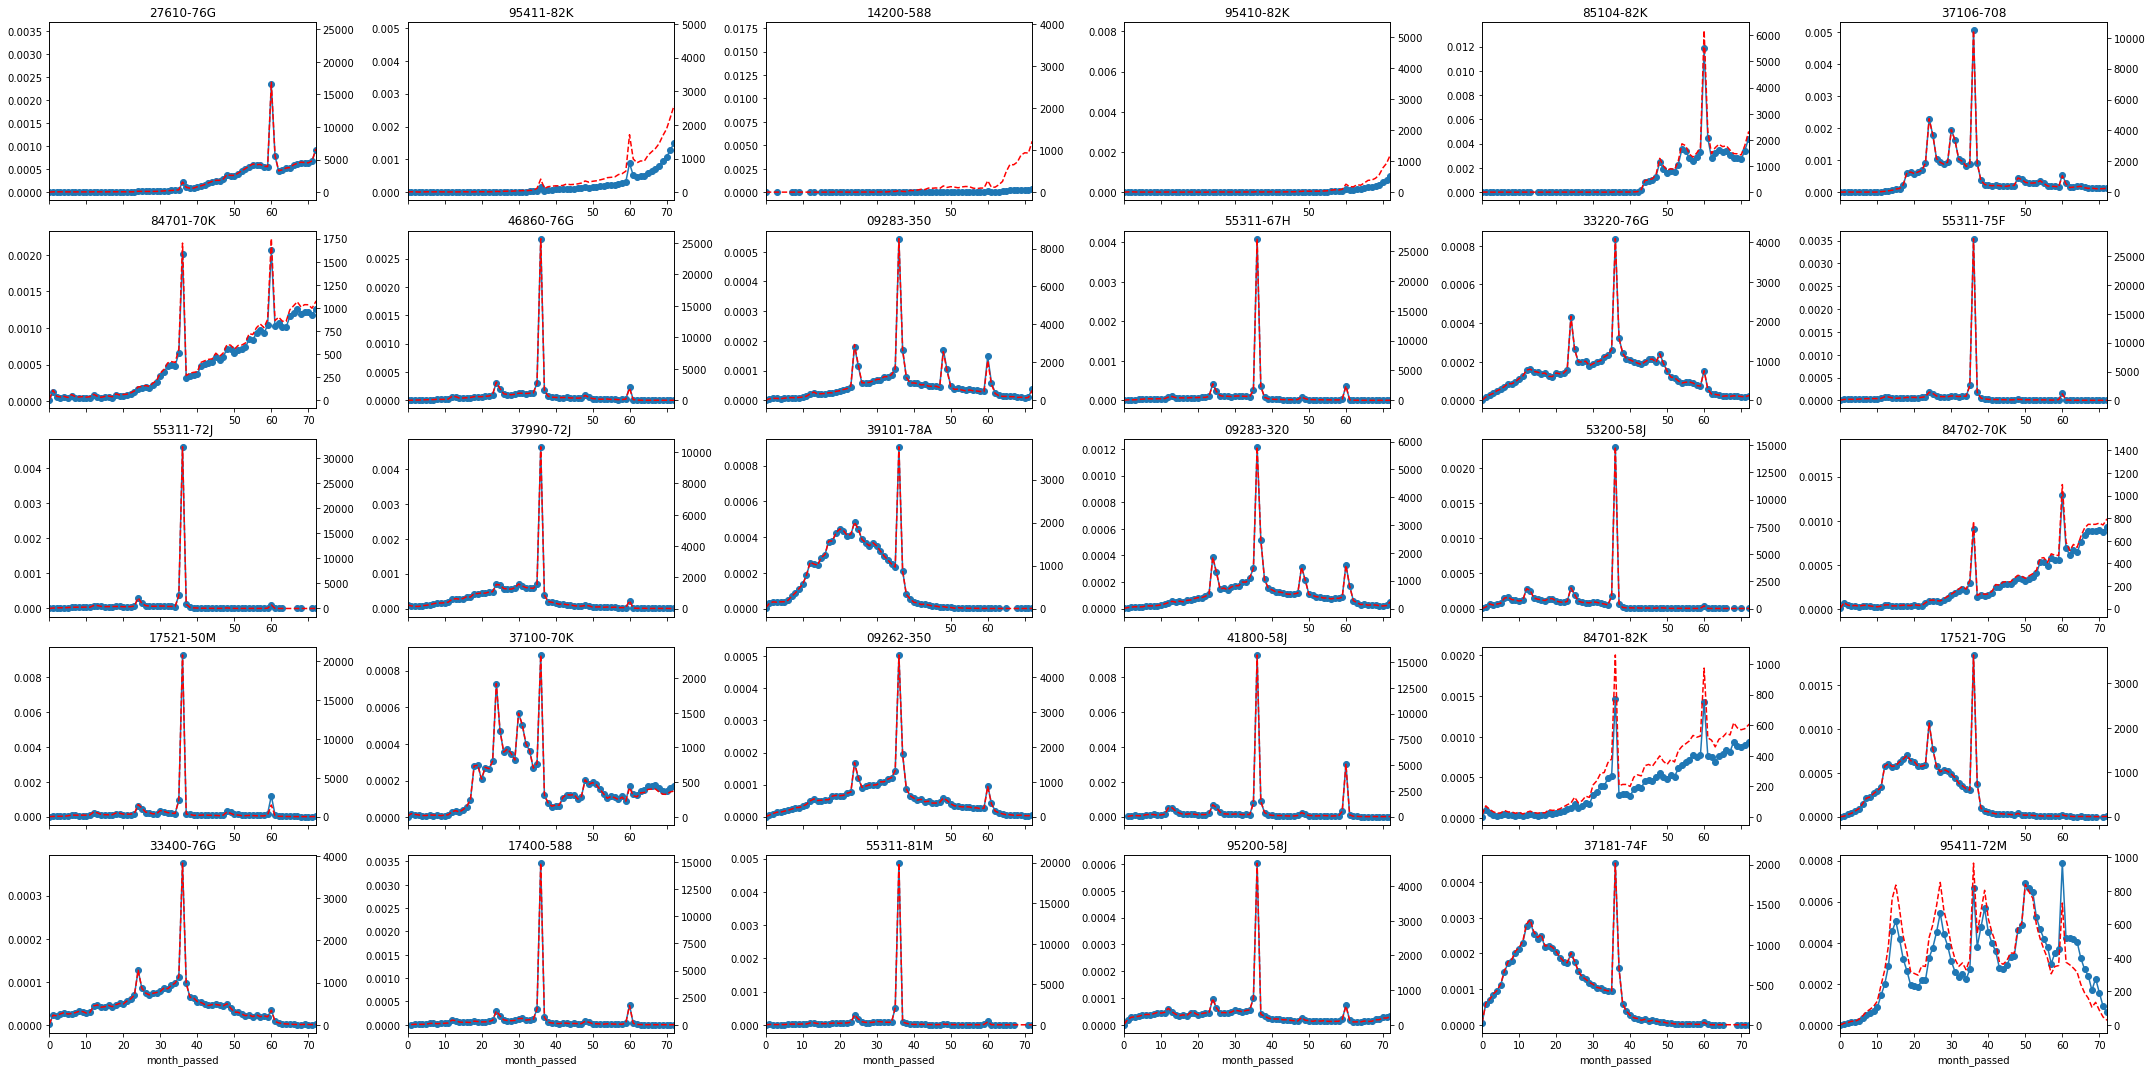

In [51]:
import numpy as np

def calc_cumsum_monthpassed(series):
    return (series.sort_index(ascending=False).cumsum()
            .reindex(np.arange(series.index.max(),-1,-1)).ffill())

fig = plt.figure(figsize=(30,15))

# ワランティ件数上位Nパーツについて図示
for i, p in enumerate(parts_top.index[:30]):
    ax = fig.add_subplot(5, 6, i + 1)
    # 対象パーツを含む機種
    model_having_parts = (df_part_model_master_selected
                          .loc[df_part_model_master_selected.part_cd == p, "model_cd"].values)

    # get number of produced model having specified parts
    fcok_model_having_parts = (df_fcok_model_num_passed
                               .loc[df_fcok_model_num_passed.prod_cd.isin(model_having_parts)]
                               .groupby("month_passed")["n"]
                               .sum()
                               .sort_index())

    # get number of warranty of specified parts
    warranty_having_parts = (df_warranty_model_part_num_date_passed
                             .loc[df_warranty_model_part_num_date_passed.part_cd == p]
                             .groupby("month_passed")["n"]
                             .sum()
                             .sort_index())

    n_part_running = calc_cumsum_monthpassed(fcok_model_having_parts)

    # pct of warranty in running parts
    pct_w = warranty_having_parts / n_part_running 

    pct_w.plot(ax=ax, style="o-", label="failure ratio", title=p)

    # formatting y-ticks to percent
    # ax.set_yticklabels(['{:,.2%}'.format(x) for x in ax.get_yticks()])
    ax.set_xlim(0, 72)
    if pct_w.max() > 1: ax.set_ylim(0, 0.3) # 極端に大きい値は表示しない

    ax2 = ax.twinx()
    
    warranty_having_parts.plot(ax=ax2, color="red", style="--", label="#warranty")
    ax2.set_xlim(0, 72)

plt.tight_layout()
plt.show()

## フーリエ変換(周期の検出)

In [52]:
df_warranty_model_part_num_daily.head()

,model_cd,part_cd,date,n
0,None,*0000-000,2003-01-22,1
1,None,*1110-CT5,2000-06-16,1
2,None,*1110-CT5,2001-07-06,1
3,None,*1110-DC5,2001-01-10,1
4,None,*1110-MA6,2000-02-05,1


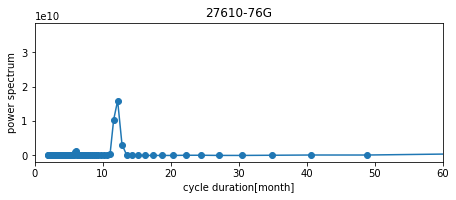

In [54]:
import numpy as np

fig = plt.figure(figsize=(30,15))
for i, p in enumerate(parts_top.index[:1]):
    ax = fig.add_subplot(6,5,i+1)
    tmp = (df_warranty_model_part_num_daily
           .loc[df_warranty_model_part_num_daily.part_cd == p]
           .groupby(pd.Grouper(key="date", freq="MS"))["n"]
           .sum()
           .resample("MS")
           .first()
           .fillna(0)
           .sort_index())
    ps = np.abs(np.fft.fft(tmp))**2
    freqs = np.fft.fftfreq(tmp.shape[0], 1)
    idx = np.argsort(freqs)
    ps_freq = pd.Series(ps[idx], index=freqs[idx])
    ps_freq = ps_freq.loc[ps_freq.index > 0]
    plt.plot(1/ps_freq.index, ps_freq, "o-")
    plt.xlim(0,60)
    plt.xlabel("cycle duration[month]")
    plt.ylabel("power spectrum")
    plt.title(p)

plt.tight_layout()

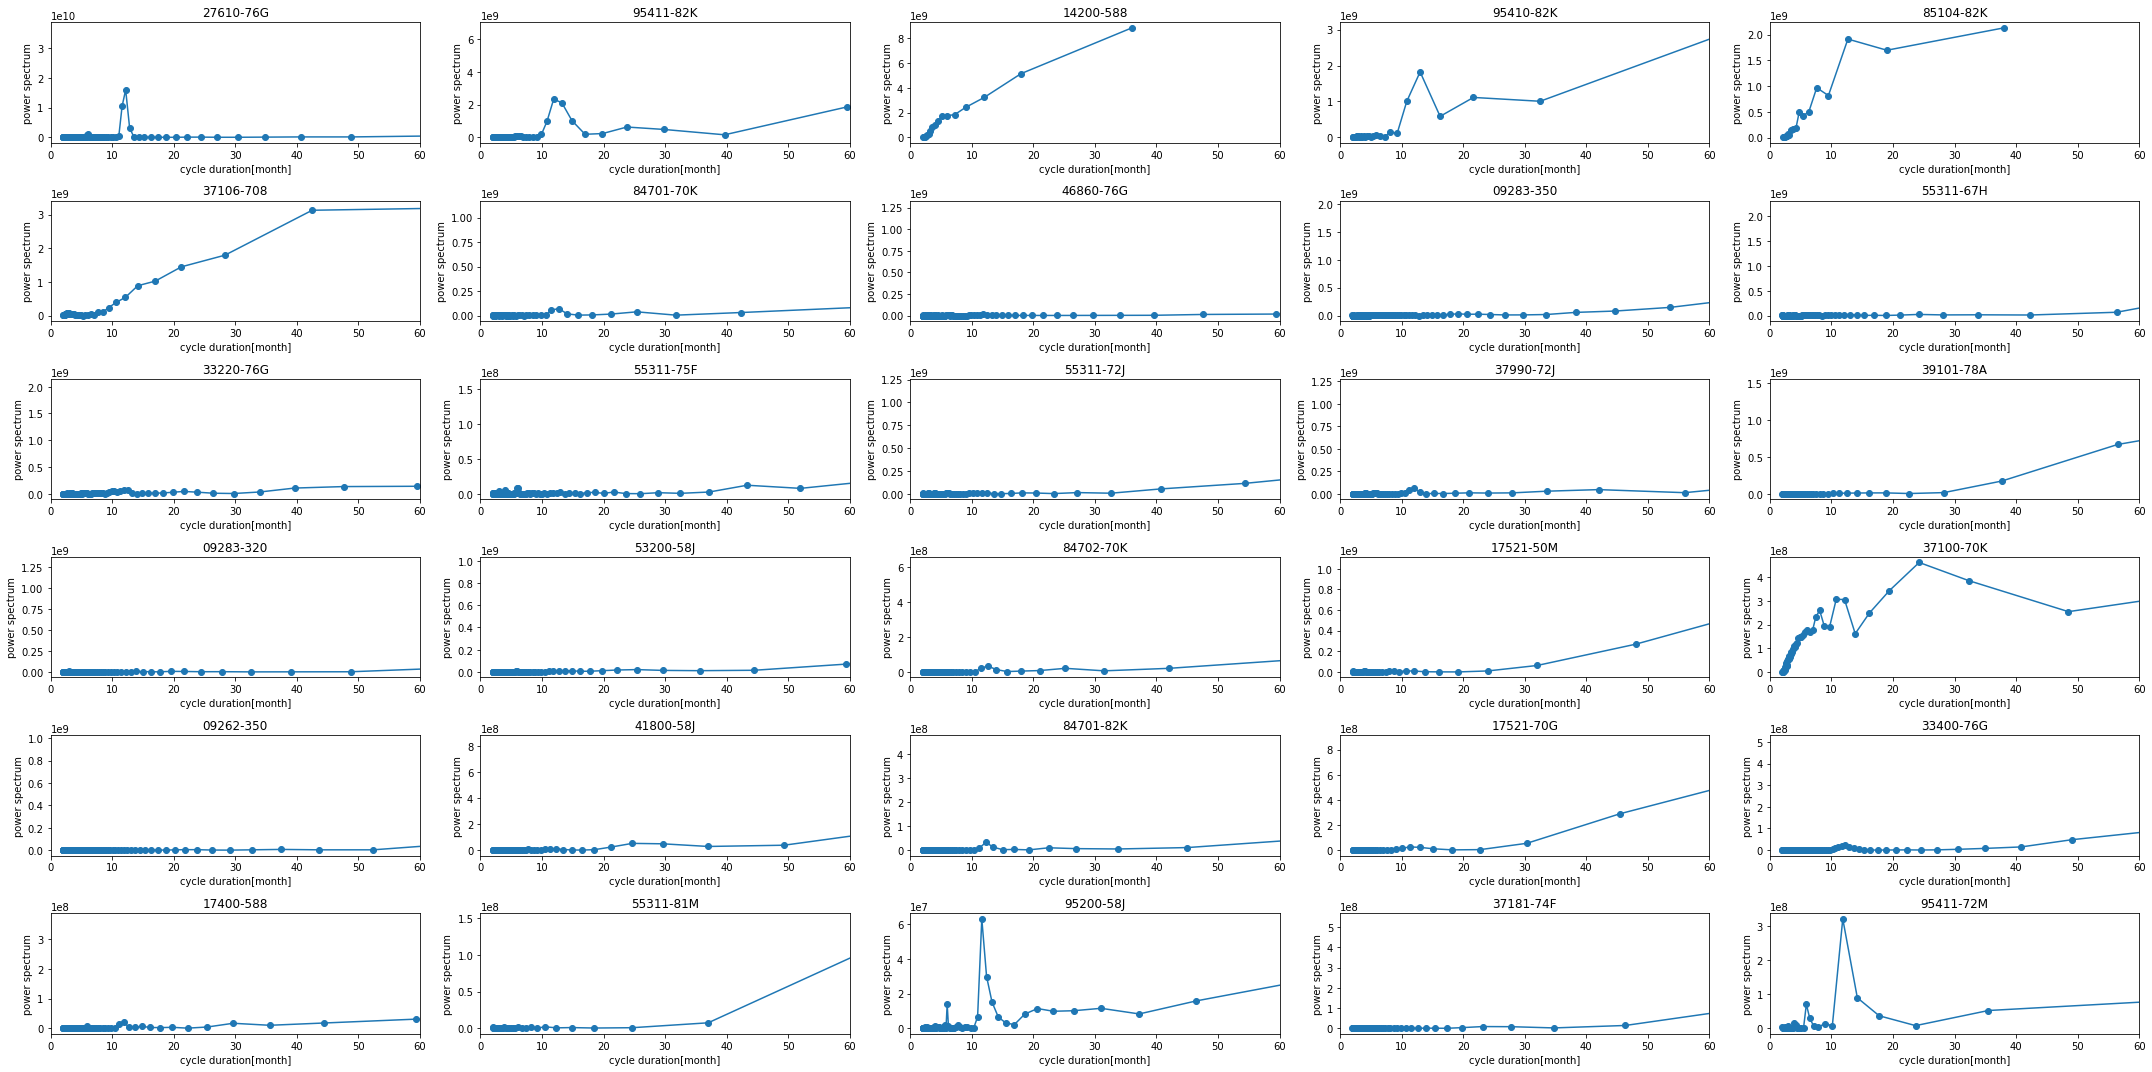

In [55]:
import numpy as np

fig = plt.figure(figsize=(30,15))
for i, p in enumerate(parts_top.index[:30]):
    ax = fig.add_subplot(6,5,i+1)
    tmp = (df_warranty_model_part_num_daily
           .loc[df_warranty_model_part_num_daily.part_cd == p]
           .groupby(pd.Grouper(key="date", freq="MS"))["n"]
           .sum()
           .resample("MS")
           .first()
           .fillna(0)
           .sort_index())
    ps = np.abs(np.fft.fft(tmp))**2
    freqs = np.fft.fftfreq(tmp.shape[0], 1)
    idx = np.argsort(freqs)
    ps_freq = pd.Series(ps[idx], index=freqs[idx])
    # ps_freq = ps_freq.loc[ps_freq.index > 0]
    plt.plot(1/ps_freq.index, ps_freq, "o-")
    plt.xlim(0,60)
    plt.xlabel("cycle duration[month]")
    plt.ylabel("power spectrum")
    plt.title(p)

plt.tight_layout()

## (付録)みせかけの相関

非定常過程をそのまま相関係数を計算と、相関の高いペアが出てきやすい。  
これに対処する方法の一つは、非定常過程に対して差分を取り、定常過程とした上で、相関係数を計算することである。

### 実データ

In [61]:
df_warranty_part_num_monthly = (df_warranty_model_part_num_daily
                                .fillna("!Unknown")
                                .groupby(["part_cd",pd.Grouper(key="date",freq="MS")])["n"]
                                .sum().reset_index())

In [63]:
df_warranty_part_num_monthly_top30 = df_warranty_part_num_monthly.loc[
    df_warranty_part_num_monthly.part_cd.isin(parts_top.index[:30])
]

In [64]:
df_warranty_part_num_monthly_top30.head()

,part_cd,date,n
11142,09262-350,1997-01-01,3
11143,09262-350,1997-02-01,6
11144,09262-350,1997-03-01,239
11145,09262-350,1997-04-01,336
11146,09262-350,1997-05-01,356


In [65]:
df_warranty_part_num_monthly_top30_pivot = (df_warranty_part_num_monthly_top30
                                            .pivot(index="month", columns="part_cd", values="n"))

KeyError: 'month'

In [ ]:
df_warranty_part_num_monthly_top30_pivot.shape

In [66]:
corr_spurious = df_warranty_part_num_monthly_top30_pivot.fillna(0).corr()

NameError: name 'df_warranty_part_num_monthly_top30_pivot' is not defined

In [ ]:
high_corr_pair = np.where(corr_spurious > 0.9)
high_corr_pair = [(i,j) for i,j in zip(high_corr_pair[0], high_corr_pair[1])
                 if i < j]

In [ ]:
len(high_corr_pair)

In [ ]:
fig = plt.figure(figsize=(10,15))
for k, (i,j) in enumerate(high_corr_pair):
    part_i = df_warranty_part_num_monthly_top30_pivot.columns[i]
    part_j = df_warranty_part_num_monthly_top30_pivot.columns[j]
    ax = fig.add_subplot(math.ceil(len(high_corr_pair)/2), 2, k+1)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,i].plot(ax=ax, label=part_i)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,j].plot(ax=ax, label=part_j)
    ax.set_title("{} vs {}".format(part_i,part_j))
    plt.legend()
plt.tight_layout()
plt.show()

9つのペアが相関が高い(0.9以上)ように見えるが...

In [67]:
corr_diff = df_warranty_part_num_monthly_top30_pivot.fillna(0).diff().corr()

NameError: name 'df_warranty_part_num_monthly_top30_pivot' is not defined

In [68]:
high_corr_pair_diff = np.where(corr_diff > 0.9)

high_corr_pair_diff = [(i,j) for i,j in zip(high_corr_pair_diff[0], high_corr_pair_diff[1])
                 if i < j]

NameError: name 'corr_diff' is not defined

In [ ]:
high_corr_pair_diff

In [ ]:
fig = plt.figure(figsize=(10,15))
for k, (i,j) in enumerate(high_corr_pair):
    part_i = df_warranty_part_num_monthly_top30_pivot.columns[i]
    part_j = df_warranty_part_num_monthly_top30_pivot.columns[j]
    ax = fig.add_subplot(math.ceil(len(high_corr_pair)/2), 2, k+1)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,i].plot(ax=ax, label=part_i)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,j].plot(ax=ax, label=part_j)
    ax.set_title("{} vs {}".format(part_i,part_j))
    plt.legend()
plt.tight_layout()
plt.show()

In [69]:
fig = plt.figure(figsize=(10,15))
for k,(i,j) in enumerate(high_corr_pair_diff):
    part_i = df_warranty_part_num_monthly_top30_pivot.columns[i]
    part_j = df_warranty_part_num_monthly_top30_pivot.columns[j]
    ax = fig.add_subplot(math.ceil(len(high_corr_pair)/2), 2, k+1)

    df_warranty_part_num_monthly_top30_pivot.iloc[:,i].plot(ax=ax)
    df_warranty_part_num_monthly_top30_pivot.iloc[:,j].plot(ax=ax)
    ax.set_title("{} vs {}".format(part_i,part_j))
    plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'high_corr_pair_diff' is not defined

<Figure size 720x1080 with 0 Axes>

差分を取ると、2ペアだけとなった。

### シミュレーション

In [70]:
np.random.randn(20)

array([ 1.57551833, -0.05245606, -0.04905565, -0.44017976, -2.62764063,
       -3.20607314,  1.07225017,  0.69719421,  1.37452869, -2.06526848,
       -0.56502362,  0.91098782, -0.57118571, -1.48047002, -0.66846671,
        0.80536122,  0.00522279, -0.50352298, -1.24268443,  1.59485264])

In [71]:
np.random.seed(0)
df_30_random_s = pd.DataFrame({"val" + str(i): np.random.randn(300) for i in range(30)}).cumsum()

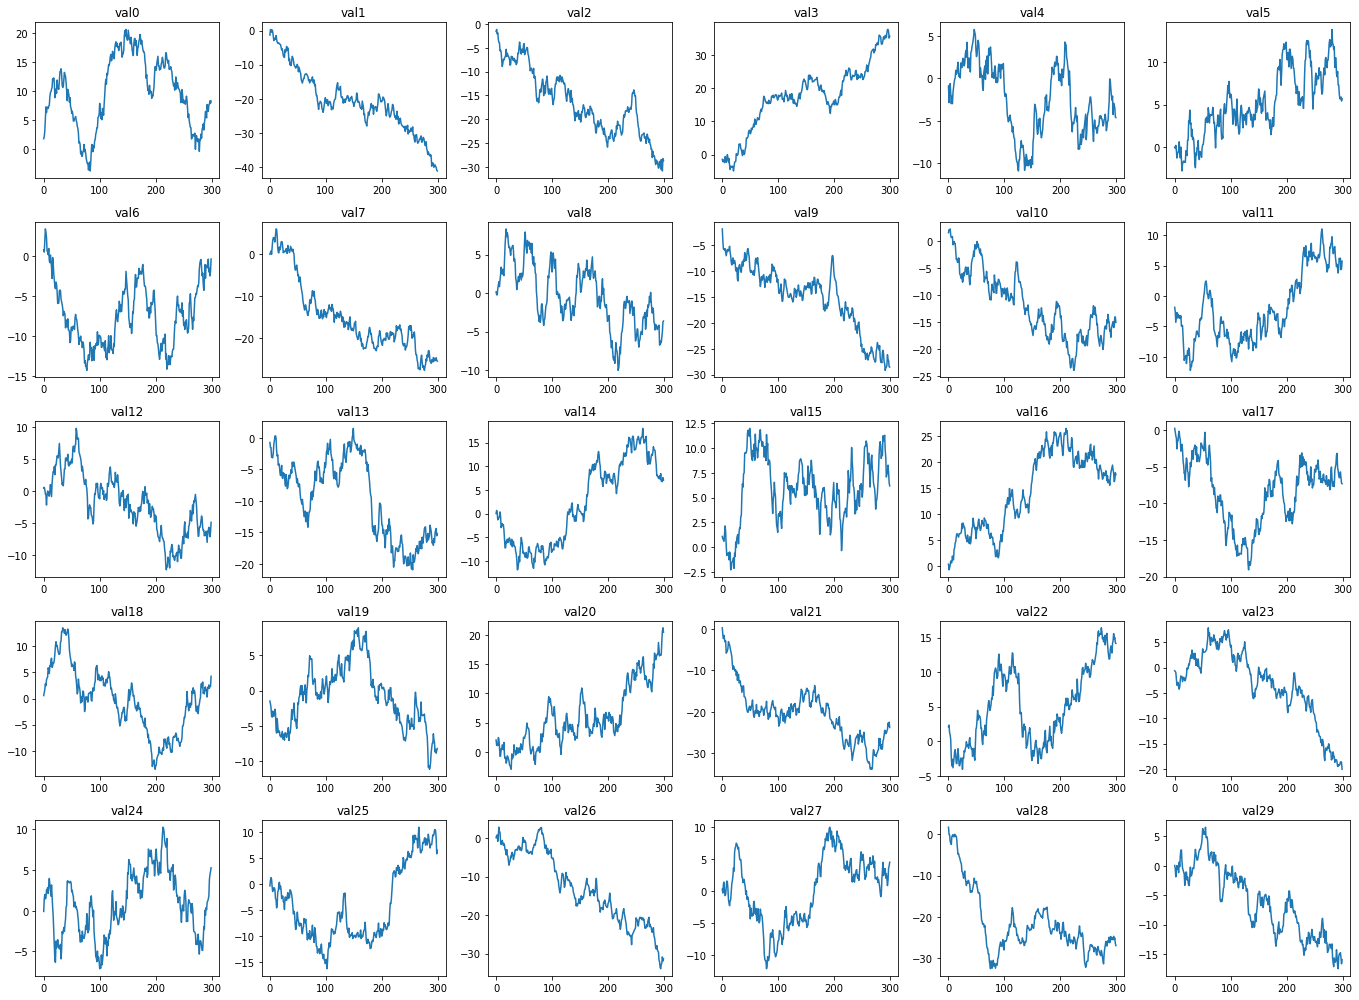

In [72]:
fig = plt.figure(figsize=(19,14))
for i, (v, s) in enumerate(df_30_random_s.iteritems()):
    ax = fig.add_subplot(5,6,i+1)
    ax.plot(s)
    ax.set_title(v)

plt.tight_layout()

In [73]:
corr_rand = df_30_random_s.corr()
corr_rand_diff = df_30_random_s.diff().corr()

high_corr_rand = np.where(corr_rand > 0.9)
high_corr_rand = [(i,j) for i,j in zip(high_corr_rand[0], high_corr_rand[1])
                 if i < j]

high_corr_rand_diff = np.where(corr_rand_diff > 0.9)
high_corr_rand_diff = [(i,j) for i,j in zip(high_corr_rand_diff[0], high_corr_rand_diff[1])
                 if i < j]

In [74]:
# 0.9以上の相関のペアがある
print(high_corr_rand)

[(1, 7)]


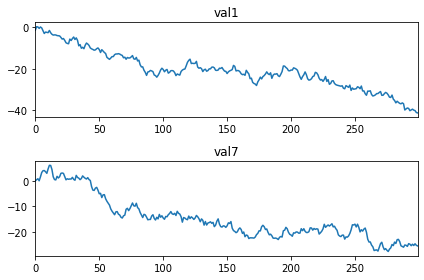

----------------------------------------------------------------------------------------------------


In [75]:
for i,j in high_corr_rand:
    fig = plt.figure()
    ax = fig.add_subplot(2,1,1)
    df_30_random_s.iloc[:,i].plot(ax=ax)
    ax.set_title(df_30_random_s.columns[i])
    
    ax = fig.add_subplot(2,1,2)
    df_30_random_s.iloc[:,j].plot(ax=ax)
    ax.set_title(df_30_random_s.columns[j])
    plt.tight_layout()
    plt.show()
    print("-" * 100)

In [76]:
# 差分の場合は0.9以上の相関のものはない
high_corr_rand_diff

[]

## (付録)DTWによる距離と、距離によるクラスタリング

In [82]:
df_warranty_part_num_monthly_top30_pivot = (df_warranty_part_num_monthly_top30
                                            .pivot_table(index="date", columns="part_cd", values="n")
                                            .fillna(0))

In [84]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from tqdm import tqdm_notebook
from itertools import chain

n = df_warranty_part_num_monthly_top30_pivot.shape[1]
distance_m = np.zeros((n, n))

seq = list(chain.from_iterable([[(i,k) for k in range(i)] for i in range(1,n)]))
for i,k in tqdm_notebook(seq):
    distance, path = fastdtw(df_warranty_part_num_monthly_top30_pivot.iloc[:,i].fillna(0),
                     df_warranty_part_num_monthly_top30_pivot.iloc[:,k].fillna(0), 
                     dist=euclidean)
    distance_m[i, k] = distance

In [85]:
for i in range(n):
    for k in range(i+1):
        if i == k:
            distance_m[k,i] = 0
        else:
            distance_m[k,i] = distance_m[i,k]

In [86]:
df_distance = pd.DataFrame(distance_m, columns=df_warranty_part_num_monthly_top30_pivot.columns,
                           index=df_warranty_part_num_monthly_top30_pivot.columns)

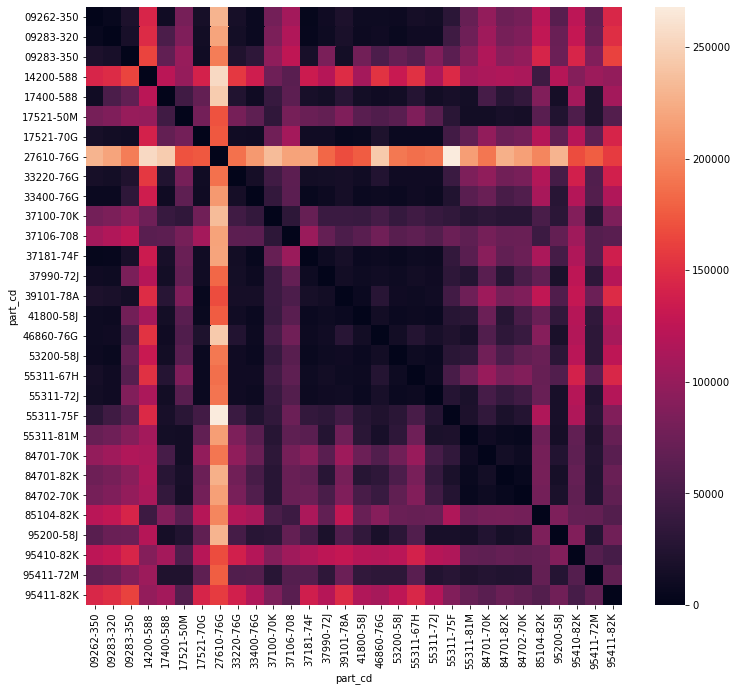

In [87]:
# DTWのヒートマップ
import seaborn as sns

plt.figure(figsize=(12,11))
sns.heatmap(df_distance);

In [88]:
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram
from scipy.spatial.distance import squareform

methods = ["single", "complete", "average", "weighted",
           "centroid", "median", "ward"]
d = squareform(distance_m, force='tovector')
for method in methods:
    Z = linkage(d, method=method)
    c, d = cophenet(Z, d)
    print("{0} {1:.3f}".format(method, c))

single 0.837
complete 1.000
average 1.000
weighted 1.000
centroid 0.998
median 0.999
ward 0.985


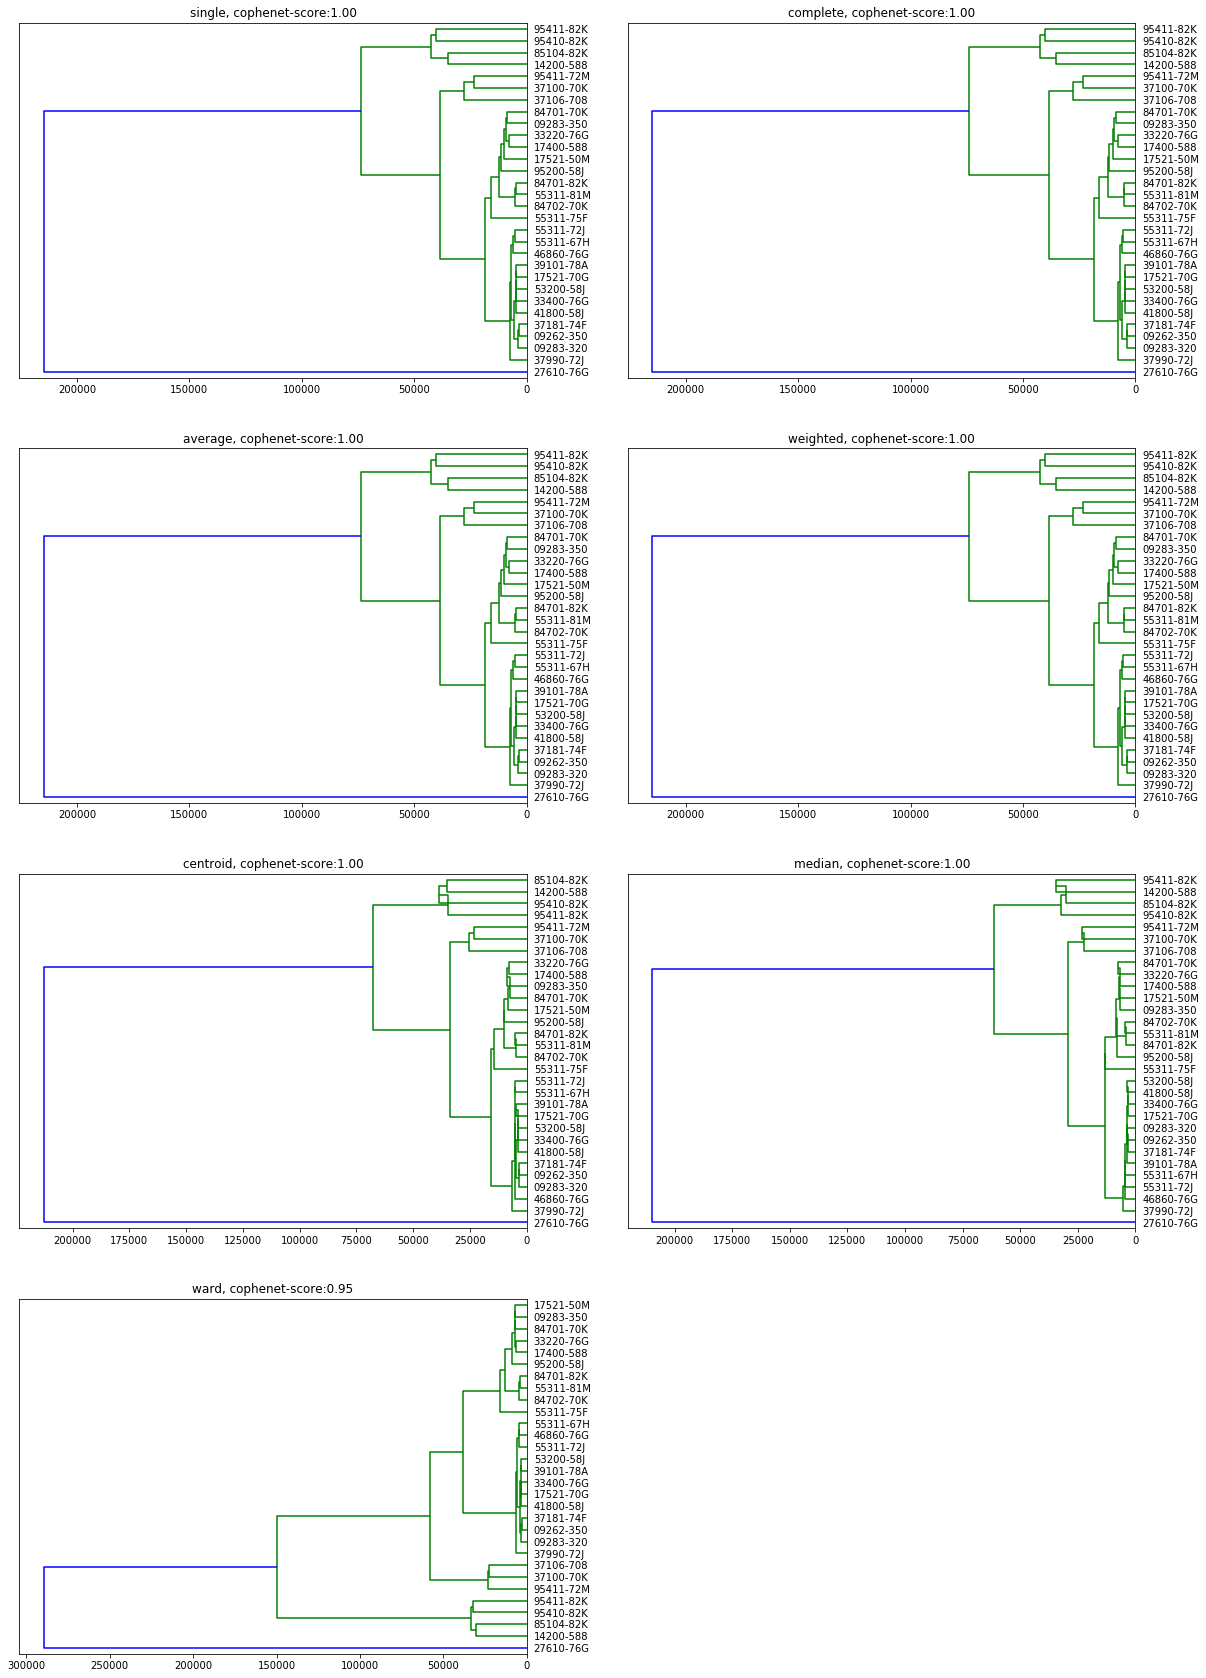

In [89]:
# クラスタリングによる樹形図
fig = plt.figure(figsize=(20,30))

for i, method in enumerate(methods):
    ax = fig.add_subplot(4, 2, i+1)
    Z = linkage(d, method=method)
    c, d = cophenet(Z, d)
    dendrogram(Z, orientation="left", labels=df_warranty_part_num_monthly_top30_pivot.columns)
    ax.set_title(f"{method}, cophenet-score:{c:.2f}")

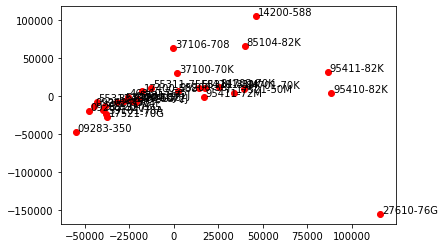

In [90]:
# 多次元尺度構成法(MDS)を用いて、距離行列から2次元座標の位置に変換
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=0)
X_r = mds.fit(distance_m).embedding_
plt.figure()
plt.scatter(X_r[:,0],X_r[:,1],c="red")
for x,y,col in zip(X_r[:,0], X_r[:,1], df_warranty_part_num_monthly_top30_pivot.columns):
    plt.annotate(col, (x+1000, y+1000))